# Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow
import glob

# Dataset

## Import Images & Annotations

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = "/content/drive/MyDrive/Indonesia-AI/Cityscape-Dataset/"

X_train_path = "images_prepped_train/"
X_test_path = "images_prepped_test/"

Y_train_path = "annotations_prepped_train/"
Y_test_path = "annotations_prepped_test/"

images_train = os.listdir(os.path.join(base_path, X_train_path))
images_test = os.listdir(os.path.join(base_path, X_test_path))

In [4]:
print(images_train)
print(images_test)

['0001TP_007590.png', '0016E5_08400.png', '0016E5_00660.png', '0016E5_05850.png', '0016E5_02220.png', '0006R0_f03390.png', '0016E5_05880.png', '0016E5_07140.png', '0016E5_01350.png', '0016E5_05040.png', '0001TP_008100.png', '0001TP_008250.png', '0006R0_f01200.png', '0006R0_f03300.png', '0016E5_05460.png', '0001TP_008370.png', '0016E5_04740.png', '0016E5_07530.png', '0016E5_06990.png', '0001TP_006900.png', '0006R0_f01320.png', '0016E5_08340.png', '0016E5_05370.png', '0016E5_01860.png', '0016E5_06180.png', '0001TP_007530.png', '0001TP_007440.png', '0016E5_08190.png', '0006R0_f01620.png', '0016E5_06270.png', '0006R0_f03870.png', '0016E5_07170.png', '0006R0_f01920.png', '0016E5_02160.png', '0006R0_f03510.png', '0006R0_f02730.png', '0016E5_08490.png', '0016E5_07320.png', '0016E5_06510.png', '0016E5_07410.png', '0006R0_f01950.png', '0006R0_f03030.png', '0016E5_07020.png', '0016E5_04980.png', '0001TP_008070.png', '0016E5_04530.png', '0016E5_07350.png', '0006R0_f01680.png', '0016E5_01560.png',

## Load the Dataset

In [5]:
def preprocess_data(filename, dir_x, dir_y, SHAPE = 416):
  # cv2.imread(path, flag). Using 0 to read image in grayscale mode
  image_x = cv2.imread(dir_x + filename, 0)
  image_y = cv2.imread(dir_y + filename, 0)

  #reshaping image to 224x224
  image_x = cv2.resize(image_x, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  image_y = cv2.resize(image_y, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  return image_x, image_y

In [6]:
images_train_arr = []
ann_train_arr = []
images_test_arr = []
ann_test_arr = []

for filename in images_train:
  img_x, img_y = preprocess_data(filename, os.path.join(base_path, X_train_path), os.path.join(base_path, Y_train_path))
  images_train_arr.append(img_x)
  ann_train_arr.append(img_y)

for filename in images_test:
  img_x, img_y = preprocess_data(filename, os.path.join(base_path, X_test_path), os.path.join(base_path, Y_test_path))
  images_test_arr.append(img_x)
  ann_test_arr.append(img_y)

images_train_arr = np.array(images_train_arr)
ann_train_arr = np.array(ann_train_arr)
images_test_arr = np.array(images_test_arr)
ann_test_arr = np.array(ann_test_arr)

In [7]:
print('images train array shape:', images_train_arr.shape)
print('ann train array shape:', ann_train_arr.shape)
print('images test array shape:', images_test_arr.shape)
print('ann train array shape:', ann_test_arr.shape)

images train array shape: (367, 416, 416)
ann train array shape: (367, 416, 416)
images test array shape: (101, 416, 416)
ann train array shape: (101, 416, 416)


# Data Preprocessing

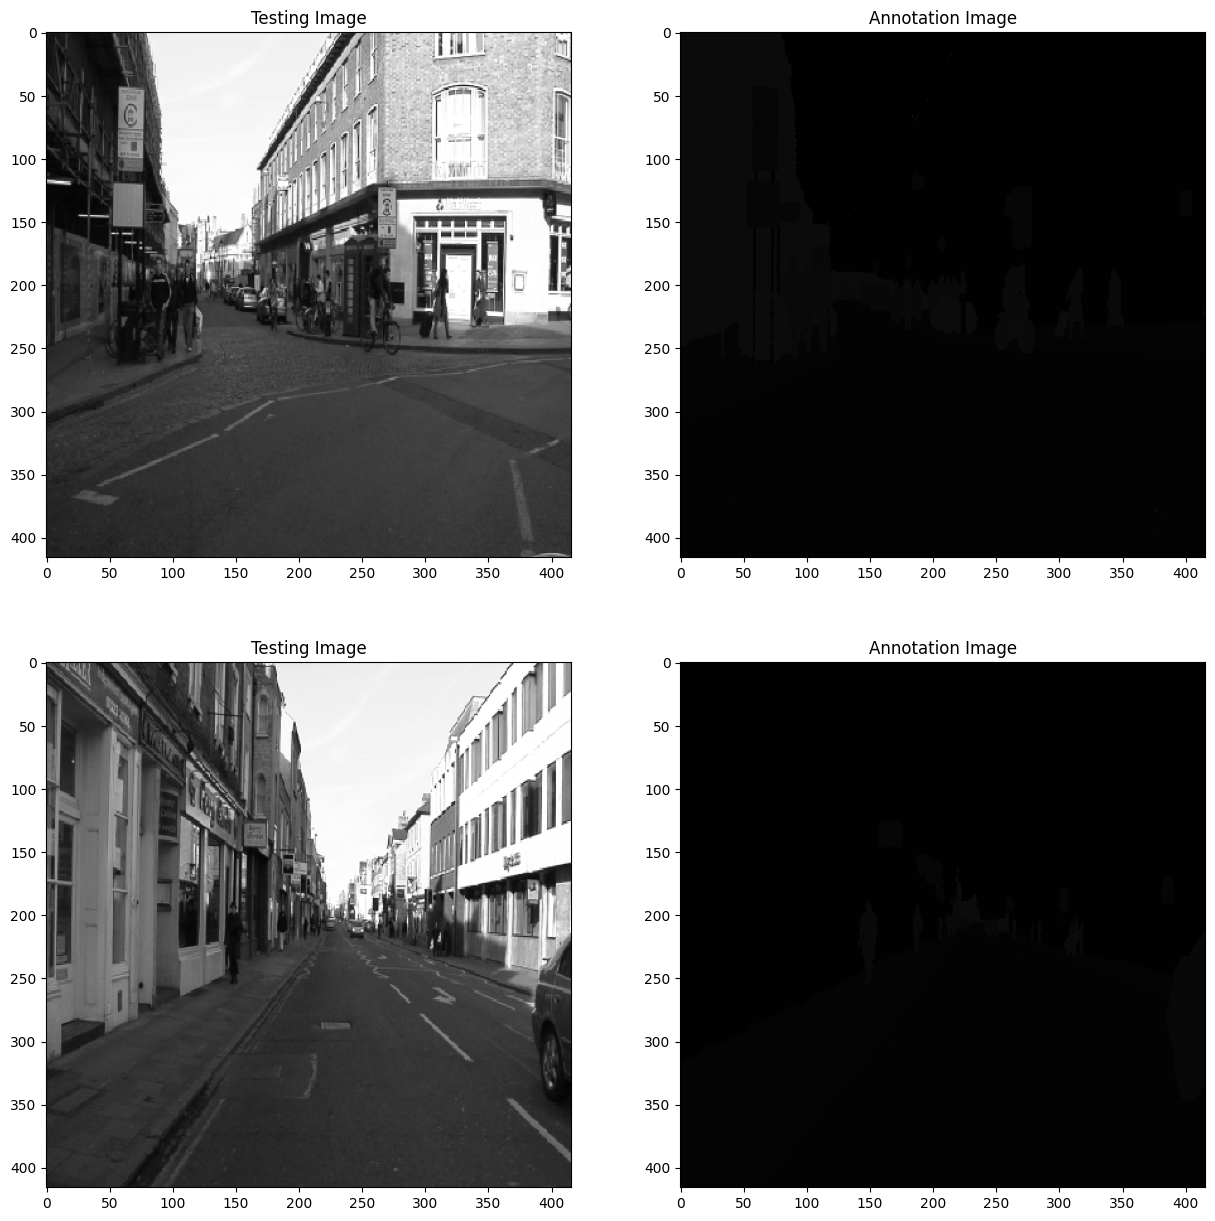

In [8]:
# plot training images
plt.figure(figsize=(15,15))
for i in range(1, 4, 2):
  plt.subplot(2, 2, i)
  plt.imshow(images_train_arr[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Testing Image')
  plt.subplot(2, 2, i+1)
  plt.imshow(ann_train_arr[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Annotation Image')
plt.show()

In [9]:
# function to get unique values
def get_class(image_y):
  array = image_y.ravel()
  return np.unique(array)

In [10]:
# get information from the dataset
print('image prepped train shape:', images_train_arr.shape)
print('annotations prepped train shape:', ann_train_arr.shape)
print('image prepped test shape:', images_test_arr.shape)
print('annotations prepped test shape:', ann_test_arr.shape)
print('data train:', len(images_train_arr))
print('data test:', len(images_test_arr))

print('\n')
print("unique value of 'annotation'")
print("kind of class :", get_class(ann_train_arr[2]))
print("number of classes:", len(get_class(ann_train_arr[2])))

print('\n')
print("unique value of 'image'")
print("kind of class :\n", get_class(images_train_arr[2]))
print("number of classes:", len(get_class(images_train_arr[2])))

image prepped train shape: (367, 416, 416)
annotations prepped train shape: (367, 416, 416)
image prepped test shape: (101, 416, 416)
annotations prepped test shape: (101, 416, 416)
data train: 367
data test: 101


unique value of 'annotation'
kind of class : [ 0  1  2  3  4  5  6  7  8  9 10 11]
number of classes: 12


unique value of 'image'
kind of class :
 [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 

## Normalize Data

In [11]:
# Data train
x = np.expand_dims(images_train_arr, axis=3)
train_x_norm = normalize(x.reshape(x.shape[0], -1), axis=1).reshape(x.shape)
train_y_norm = np.expand_dims(ann_train_arr, axis=3)

# Data test
x_test = np.expand_dims(images_test_arr, axis=3)
test_x_norm = normalize(x_test.reshape(x_test.shape[0], -1), axis=1).reshape(x_test.shape)
test_y_norm = np.expand_dims(ann_test_arr, axis=3)


In [12]:
# after normalization data
print('Train images shape:', train_x_norm.shape)
print('Train annots shape:', train_y_norm.shape)
print('Test images shape:', test_x_norm.shape)
print('Test annots shape:', test_y_norm.shape)

Train images shape: (367, 416, 416, 1)
Train annots shape: (367, 416, 416, 1)
Test images shape: (101, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)


## Split Dataset

In [13]:
# split train data -> train & validation data
train_x, val_x, train_y, val_y = train_test_split(train_x_norm, train_y_norm, test_size=0.2, random_state=14)
print('Train images shape:', train_x.shape)
print('Valid images shape:', val_x.shape)
print('Train annots shape:', train_y.shape)
print('Valid images shape:', val_y.shape)

# test = test_norm
test_x, test_y = test_x_norm, test_y_norm
print('Test annots shape:', test_x.shape)
print('Test images shape:', test_y.shape)

Train images shape: (293, 416, 416, 1)
Valid images shape: (74, 416, 416, 1)
Train annots shape: (293, 416, 416, 1)
Valid images shape: (74, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)
Test images shape: (101, 416, 416, 1)


## Encode Annotations Dataset

In [14]:
# num of classes
n_classes = 12

# One Hot Encoding Train Data Annotation
train_y_cat = keras.utils.to_categorical(train_y, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = keras.utils.to_categorical(val_y, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

In [15]:
# after encode annotations dataset
print('Class values in the dataset are:', get_class(train_y[0]))
print('Train images shape', train_x.shape)
print('Train labels shape', train_y_cat.shape)

print('\nClass values in the dataset are:', get_class(val_y[0]))
print('Validation images shape', val_x.shape)
print('Validation labels shape', val_y_cat.shape)

print('\nClass values in the dataset are:', get_class(test_y[0]))
print('Test images shape', test_x.shape)
print('Test labels shape', test_y_cat.shape)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 11]
Train images shape (293, 416, 416, 1)
Train labels shape (293, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Validation images shape (74, 416, 416, 1)
Validation labels shape (74, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test images shape (101, 416, 416, 1)
Test labels shape (101, 416, 416, 12)


# Build the Model
Using FCN or UNet

In [16]:
def UNet(image_size, ch_in=1, ch_out=3):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # The Contraction Path
  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) #Dropout sifatnya opsional

  # The Expansion Path
  # Blok 6
  up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(dropout5))
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Blok 7
  up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Blok 8
  up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Blok 9
  up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  unit = 12
  conv10 = Conv2D(unit, 1, activation='relu')(conv9)
  conv10 = Conv2D(unit, 1, activation='softmax')(conv10)

  outputs = conv10

  model = Model(inputs, outputs)

  return model

In [17]:
model = UNet(image_size=(416, 416))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 416, 416, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 64)         640       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 416, 416, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 208, 208, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

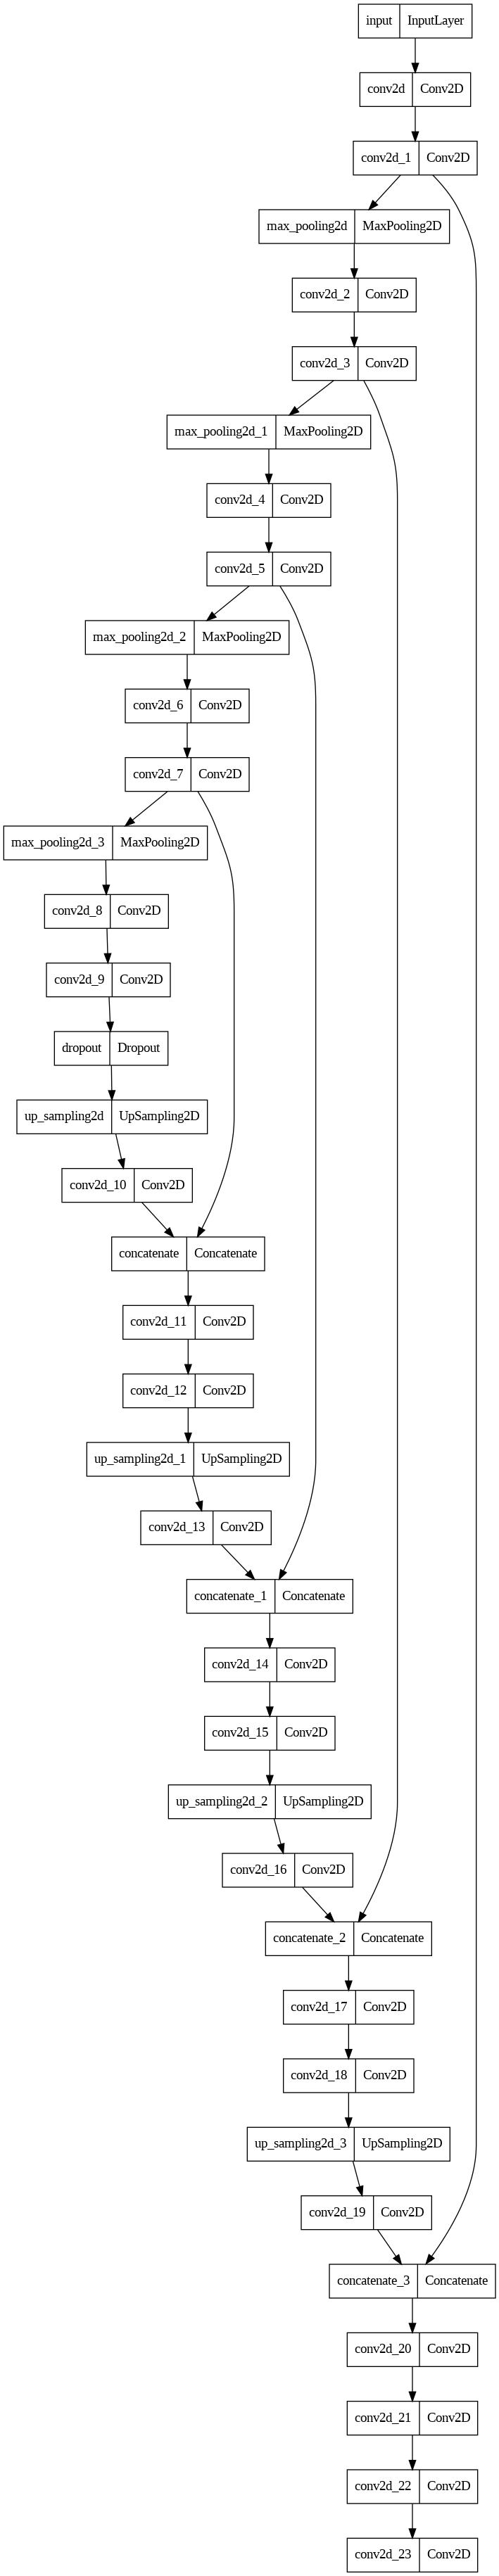

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png')

## Train the Model

In [19]:
batch_size = 8
epoch = 50

# Checkpoint
model_dir = "/content/model/"
model_name = f'model.h5'
model_path = os.path.join(model_dir, model_name)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.0001, verbose = 1, restore_best_weights = True)

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[model_checkpoint, early_stopping])

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 2.3023 - accuracy: 0.2293

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 220s 4s/step - loss: 2.3023 - accuracy: 0.2293 - val_loss: 2.0332 - val_accuracy: 0.3294
Epoch 2/50
37/37 [==============================] - 116s 3s/step - loss: 2.0048 - accuracy: 0.3176 - val_loss: 1.9280 - val_accuracy: 0.3317
Epoch 3/50
37/37 [==============================] - 68s 2s/step - loss: 1.9067 - accuracy: 0.3201 - val_loss: 1.8058 - val_accuracy: 0.3302
Epoch 4/50
37/37 [==============================] - 132s 4s/step - loss: 1.7832 - accuracy: 0.3499 - val_loss: 1.6601 - val_accuracy: 0.4542
Epoch 5/50
37/37 [==============================] - 69s 2s/step - loss: 1.6483 - accuracy: 0.4119 - val_loss: 1.5616 - val_accuracy: 0.4407
Epoch 6/50
37/37 [==============================] - 144s 4s/step - loss: 1.5109 - accuracy: 0.5242 - val_loss: 1.4730 - val_accuracy: 0.5482
Epoch 7/50
37/37 [==============================] - 69s 2s/step - loss: 1.4298 - accuracy: 0.5441 - val_loss: 1.4069 - val_accuracy: 0.5409
Epoch 8/50
37/37 [=========

## Plot Figure Training and Validation

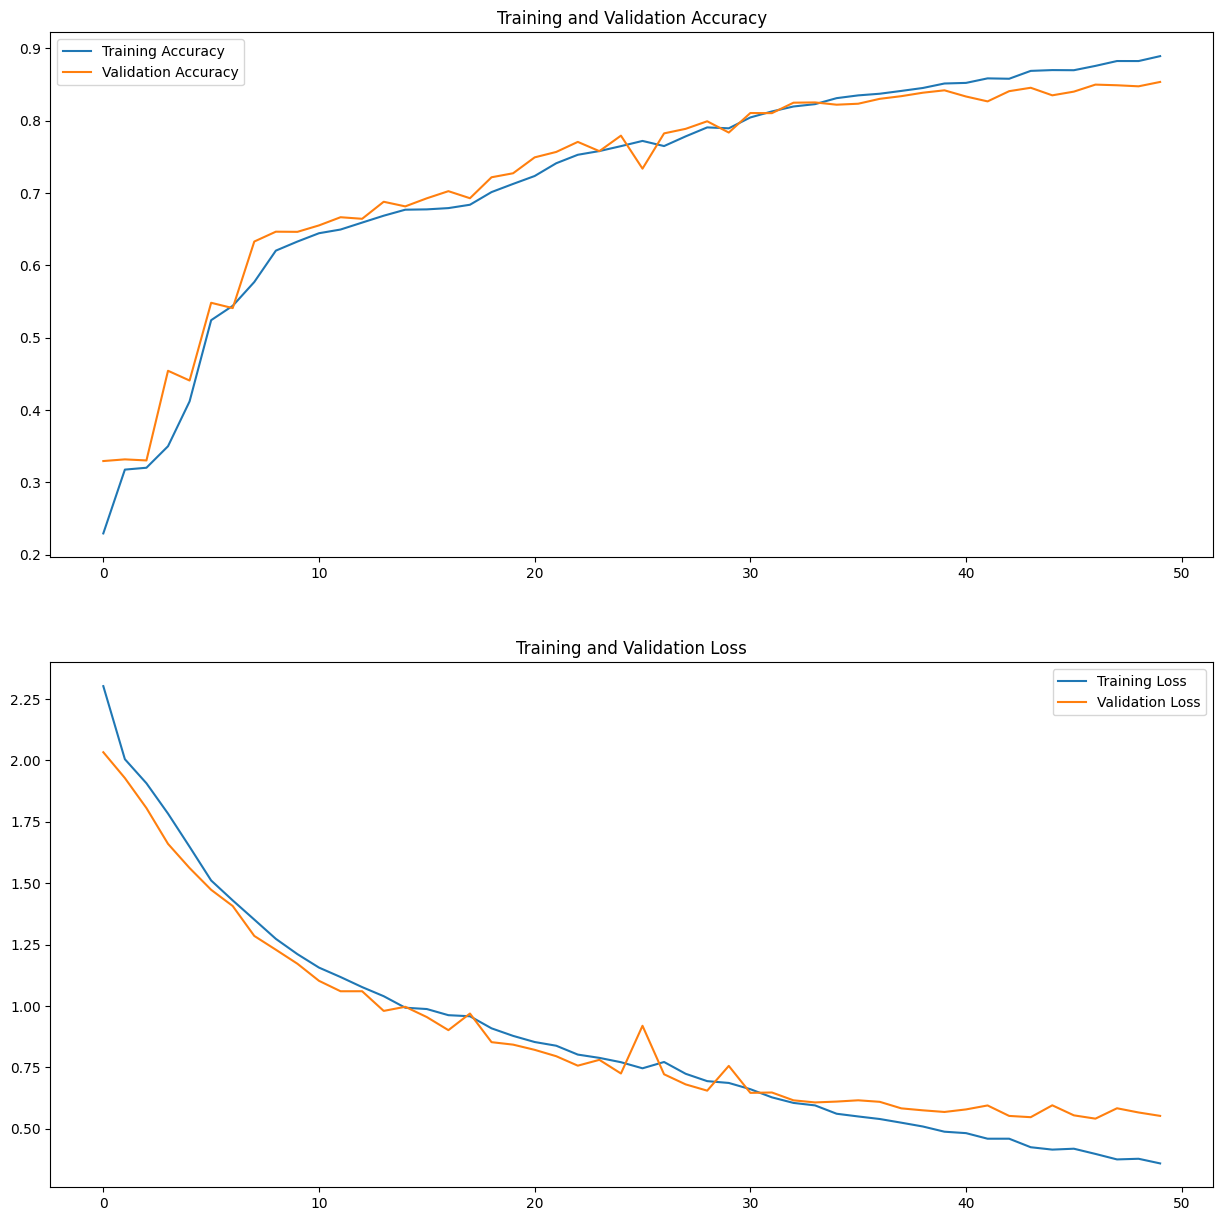

In [20]:
# Plot training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')

plt.title(f'Training and Validation Loss')

plt.show()

# Load the Model

In [22]:
# load the model and weight
load_model = keras.models.load_model("/content/model/model.h5")

## Evaluate the Model

In [23]:
# Evaluate the model with the same amount of validation data
# test_x_norm[:37], test_y_cat[:37]
score = load_model.evaluate(test_x[:10], test_y_cat[:10], verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7630259990692139
Test accuracy: 0.8040651679039001


## Check the Model Prediction

In [30]:
n_classes=12
# give color annota img
def give_color_to_annota_img(annota_img):
  random_colors = []

  for i in range(5000):
    random.seed(i)
    randColor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    random_colors.append(randColor)

  annota_img_zeros = np.zeros((416, 416, 3))
  for j in range(n_classes):
    annota_img_zeros[:, :, 0] += ((annota_img[:, :, 0] == j)*(random_colors[j][0])).astype('uint8')
    annota_img_zeros[:, :, 1] += ((annota_img[:, :, 0] == j)*(random_colors[j][1])).astype('uint8')
    annota_img_zeros[:, :, 2] += ((annota_img[:, :, 0] == j)*(random_colors[j][2])).astype('uint8')

  annota_img_zeros = cv2.cvtColor(np.array(annota_img_zeros, dtype=np.uint8), cv2.COLOR_BGR2RGB)
  return annota_img_zeros

# plot grayscale img
def plot_img(input_img, title='', iter=0):
  N_ch = input_img.shape[2]
  if N_ch == 1:
    plt.imshow(input_img[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title(title + f' {[iter]}')
  elif N_ch == 3:
    plt.imshow(input_img)
    plt.title(title + f' {[iter]}')
  else:
    print('error image')
    return
  # set the spacing between subplots
  plt.subplots_adjust(bottom=0.1, top=0.5)

# invert encoding (to_categorical) to original data
def invert_from_cat(img_cat):
  inverted = tf.keras.backend.argmax(img_cat)
  inverted_1dims = np.expand_dims(inverted, axis=2)
  return inverted_1dims

# preprocessing to predict
def prepare(filename):
  IMAGE_CHANNEL = 1 # or 3
  IMG_SIZE = 416
  new_array = cv2.resize(filename, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

# IoU of Each Class
def get_IoU_of_class(annota_img, pred_img):
  from keras.metrics import MeanIoU
  val,sum3 = 0,0
  IoU_arr = []
  IoU_keras = MeanIoU(num_classes=n_classes)
  IoU_keras.update_state(annota_img, pred_img)
  values = np.array(IoU_keras.get_weights()).reshape(n_classes, n_classes)
  print("IoU of Each Class:")
  for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    for k in range(n_classes):
        if k != i:
            sum2 = values[k, i] + sum2
        else:
            continue
    sum3 = sum1 + sum2
    IoU_arr.append(val/sum3)
    print(f"IoU Class {i}: {val/sum3*100:.2f}%")
  print(f"Mean IoU: {IoU_keras.result().numpy()*100:.2f}%")

  plt.figure(figsize=(8, 5))
  plt.bar(np.arange(0, len(IoU_arr)), IoU_arr)
  plt.xticks(np.arange(0, len(IoU_arr)))
  plt.ylabel("IoU")
  plt.xlabel("Class")
  plt.title("IoU of Each Class")

# Function to predict
# input: 1 image from test_x & test_y_cat
def predict_annotation(img_x, img_y, iter=0):
  # inverse from normalize data
  grayscale_img = img_x*255*255

  # predict image
  prediction = load_model.predict([prepare(img_x)])
  prediction_reshape = prediction.reshape((416, 416, 12)) # test_y_cat[0].shape

  # invert predict from categorical
  pred_invert = invert_from_cat(prediction_reshape)
  annota_img = invert_from_cat(img_y)

  # give color to pred_invert image
  colored_annota_img = give_color_to_annota_img(annota_img)
  colored_pred = give_color_to_annota_img(pred_invert)

  # masked image
  grayscale_img3ch = np.zeros((416, 416, 3))
  grayscale_img3ch = np.expand_dims(grayscale_img3ch, axis=3)

  grayscale_img3ch[:,:,0] += grayscale_img
  grayscale_img3ch[:,:,1] += grayscale_img
  grayscale_img3ch[:,:,2] += grayscale_img
  grayscale_img3ch2 = grayscale_img3ch.reshape(grayscale_img3ch.shape[0],grayscale_img3ch.shape[1], grayscale_img3ch.shape[2])
  masked_image = cv2.addWeighted(np.array(grayscale_img3ch2, dtype=np.uint8), 0.5, np.array(colored_pred, dtype=np.uint8), 0.5, 0)

  # plot image
  img_arr = [grayscale_img, annota_img, colored_annota_img, pred_invert, colored_pred, masked_image]
  title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']

  # Calculate number of rows and columns
  num_rows = len(img_arr) // 3  # Adjust as needed
  num_cols = 3

  plt.figure(figsize=(20, 20))
  for i in range(len(img_arr)):
      plt.subplot(num_rows, num_cols, i + 1)
      plot_img(img_arr[i], title_arr[i], iter)

  # IoU of Each Class
  get_IoU_of_class(annota_img, pred_invert)

  # plot figure
  plt.tight_layout()
  plt.show()



1/1 [==============================] - 0s 19ms/step
IoU of Each Class:
IoU Class 0: 95.16%
IoU Class 1: 71.90%
IoU Class 2: 0.00%
IoU Class 3: 93.70%
IoU Class 4: 77.26%
IoU Class 5: 75.15%
IoU Class 6: 0.00%
IoU Class 7: 1.71%
IoU Class 8: 21.24%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 4.68%
Mean IoU: 36.73%


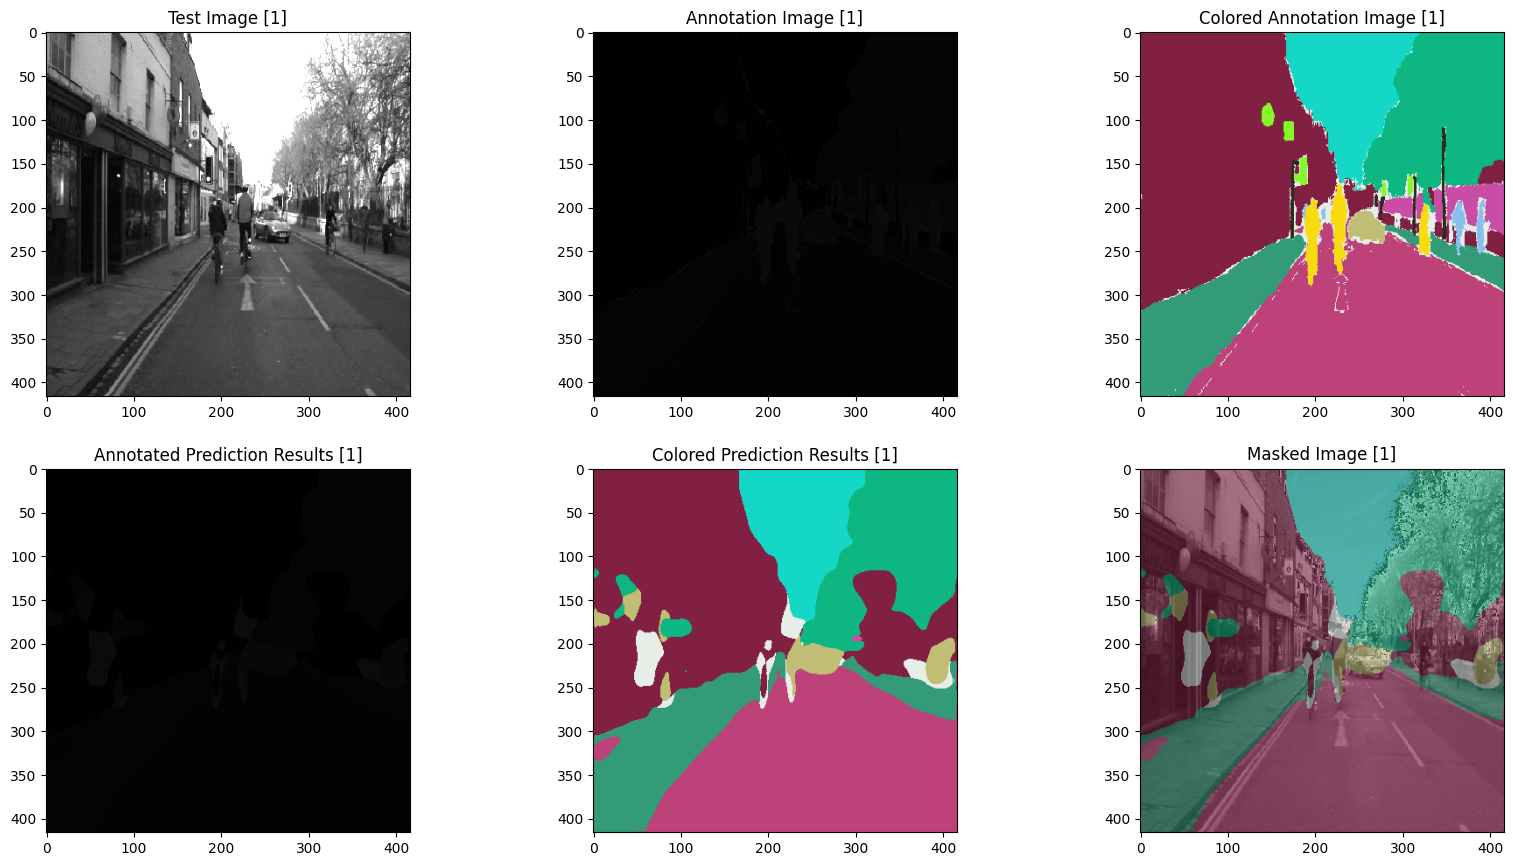

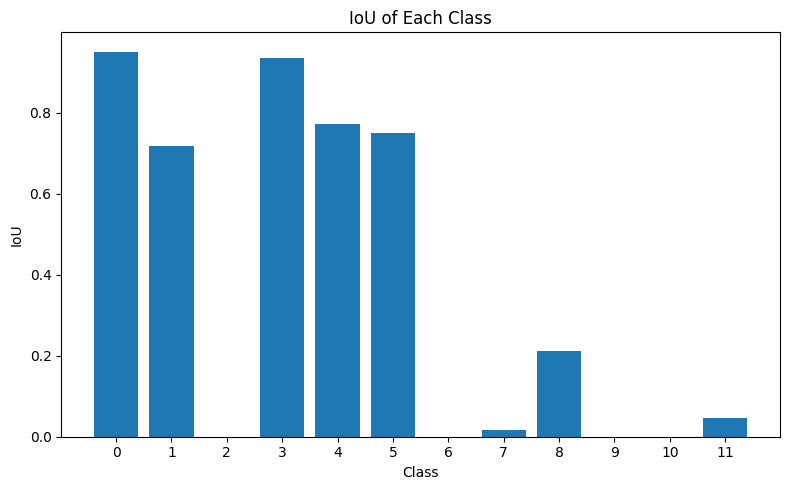

In [31]:
# testing the function
predict_annotation(test_x[0], test_y_cat[0], 1)

1/1 [==============================] - 0s 19ms/step
IoU of Each Class:
IoU Class 0: 93.98%
IoU Class 1: 59.28%
IoU Class 2: 0.00%
IoU Class 3: 90.50%
IoU Class 4: 69.96%
IoU Class 5: 57.59%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 15.91%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 8.26%
Mean IoU: 32.96%


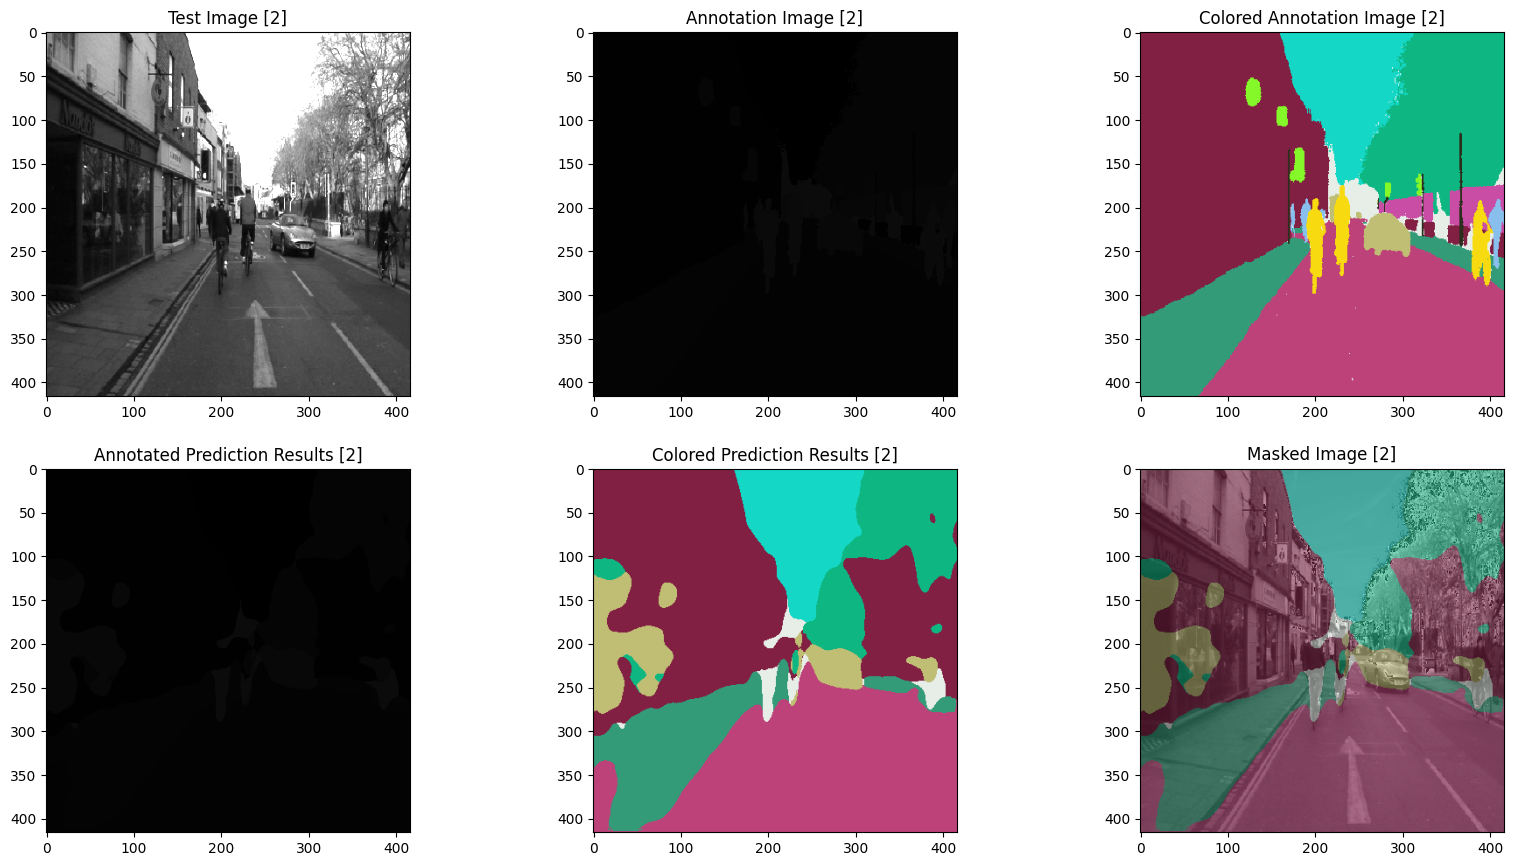

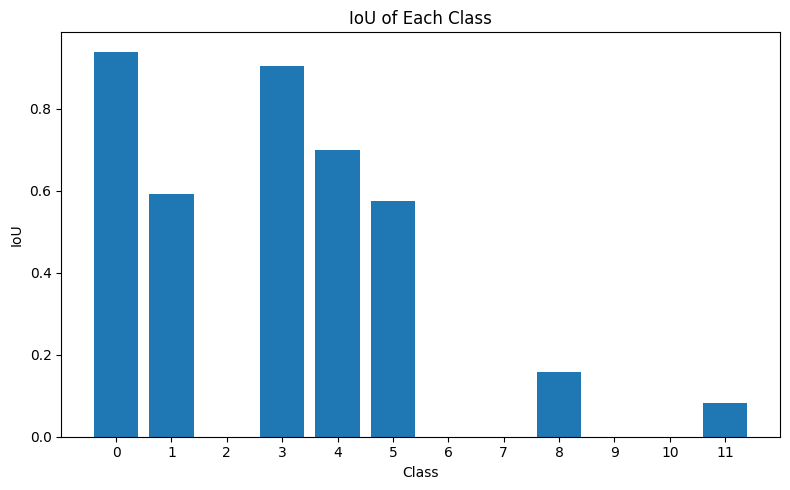

In [32]:
# testing the function
predict_annotation(test_x[1], test_y_cat[1], 2)

1/1 [==============================] - 0s 19ms/step
IoU of Each Class:
IoU Class 0: 94.13%
IoU Class 1: 73.81%
IoU Class 2: 0.00%
IoU Class 3: 89.02%
IoU Class 4: 70.28%
IoU Class 5: 70.01%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 62.05%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 7.63%
Mean IoU: 38.91%


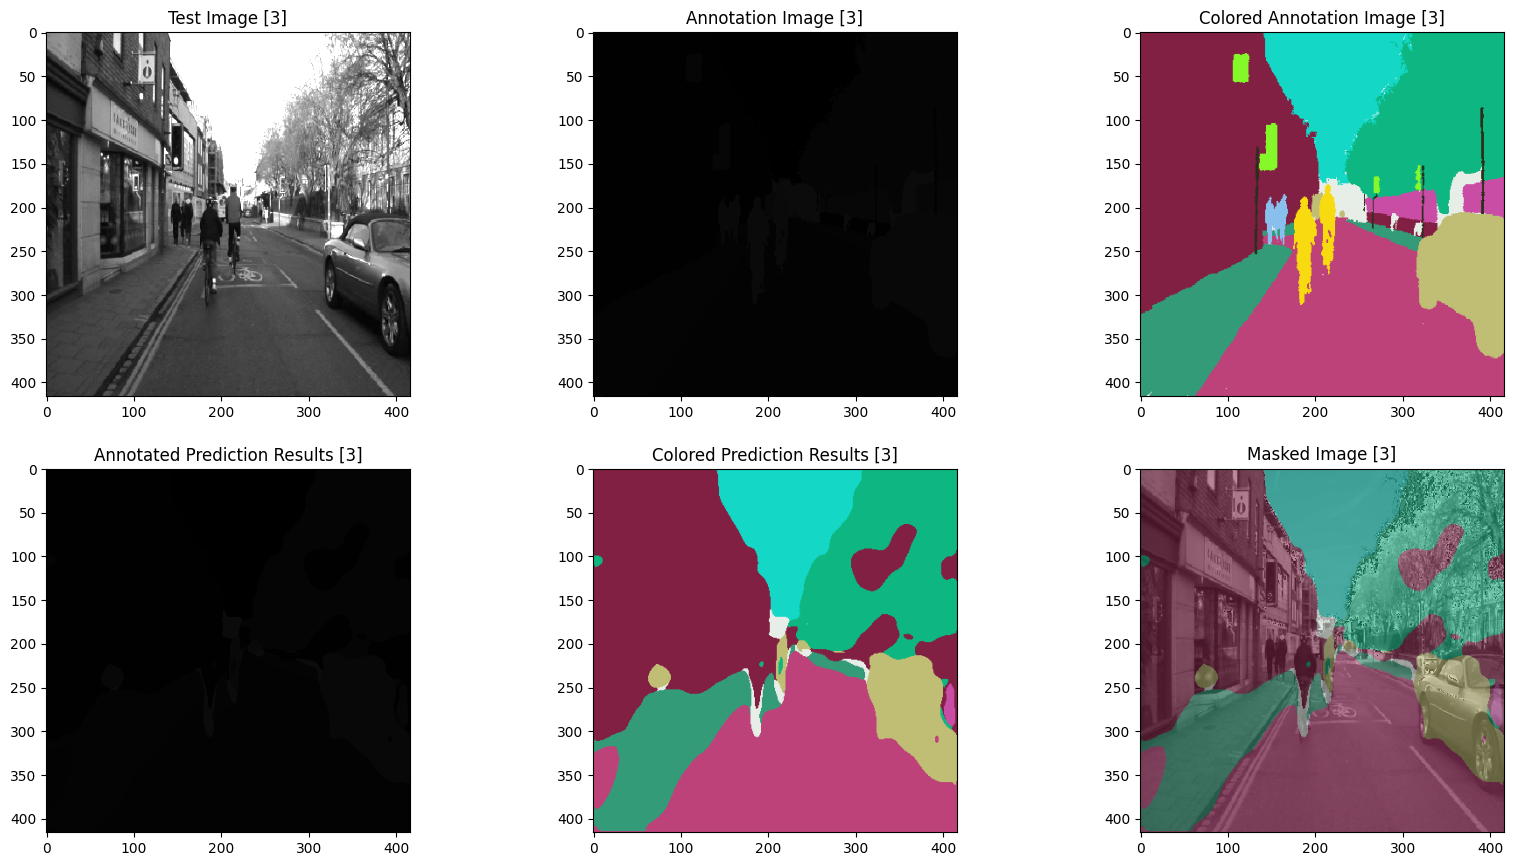

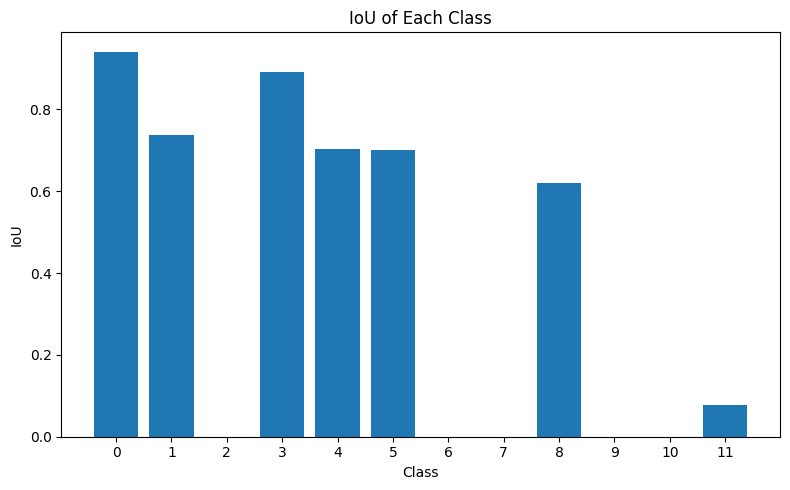

In [33]:
# testing the function
predict_annotation(test_x[2], test_y_cat[2], 3)